In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

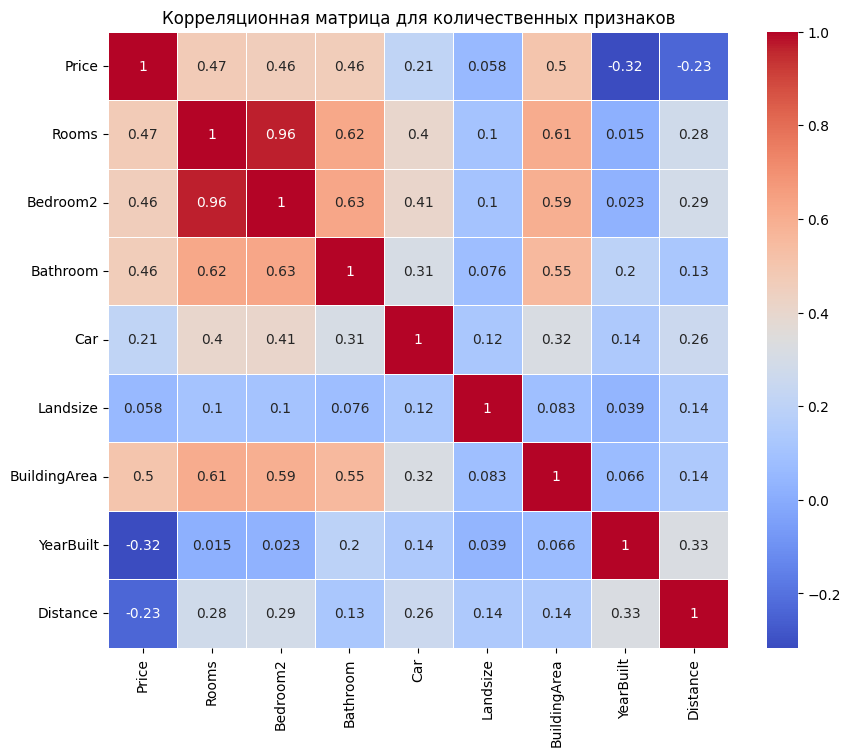

In [44]:
df = pd.read_csv('Melbourne_housing_FULL.csv')

df = df.dropna(subset=['Price', 'Rooms', 'Landsize', 'BuildingArea', 'YearBuilt'])

num_columns = ['Price', 'Rooms', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Distance']
corr_matrix = df[num_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Корреляционная матрица для количественных признаков')
plt.show()

## Оценка нормальности выборок

Для проверки нормальности распределения данных воспользуемся интервалами вероятностей, характерными для нормального распределения. Ожидаем, что данные будут примерно соответствовать следующим вероятностям:

- &mu; ± &sigma;: 68% значений
- &mu; ± 2&sigma;: 95% значений
- &mu; ± 3&sigma;: 99.7% значений

На основе этого можно сделать выводы о том, насколько распределения в данных о `Price`, `Landsize`, `BuildingArea` и `YearBuilt` близки к нормальным.


In [14]:
import numpy as np
from scipy import stats

def check_normality(samples: pd.Series, name: str):
    loc = samples.mean()
    scale = samples.std()

    print(f"\nАнализ нормальности для {name}:")
    for i in range(1, 4):
        theoretical = stats.norm.cdf(i) - stats.norm.cdf(-i)
        sample = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]
        print(f"{i} sigma: теоретическое значение = {theoretical:.3f}, выборочное значение = {sample:.3f}")

for col in ['Price', 'Landsize', 'BuildingArea', 'YearBuilt']:
    check_normality(df[col], col)



Анализ нормальности для Price:
1 sigma: теоретическое значение = 0.683, выборочное значение = 0.825
2 sigma: теоретическое значение = 0.954, выборочное значение = 0.955
3 sigma: теоретическое значение = 0.997, выборочное значение = 0.983

Анализ нормальности для Landsize:
1 sigma: теоретическое значение = 0.683, выборочное значение = 0.981
2 sigma: теоретическое значение = 0.954, выборочное значение = 0.990
3 sigma: теоретическое значение = 0.997, выборочное значение = 0.993

Анализ нормальности для BuildingArea:
1 sigma: теоретическое значение = 0.683, выборочное значение = 0.829
2 sigma: теоретическое значение = 0.954, выборочное значение = 0.967
3 sigma: теоретическое значение = 0.997, выборочное значение = 0.988

Анализ нормальности для YearBuilt:
1 sigma: теоретическое значение = 0.683, выборочное значение = 0.618
2 sigma: теоретическое значение = 0.954, выборочное значение = 0.955
3 sigma: теоретическое значение = 0.997, выборочное значение = 0.999


# Визуальный анализ нормальности распределений

Построим гистограммы для интересующих нас признаков (`Price`, `Landsize`, `BuildingArea`, `YearBuilt`) и наложим на них графики нормального распределения. Параметры нормального распределения (математическое ожидание и стандартное отклонение) будут рассчитаны на основе значений каждого признака. 

Это позволит визуально оценить, насколько распределение данных для каждого признака близко к нормальному.


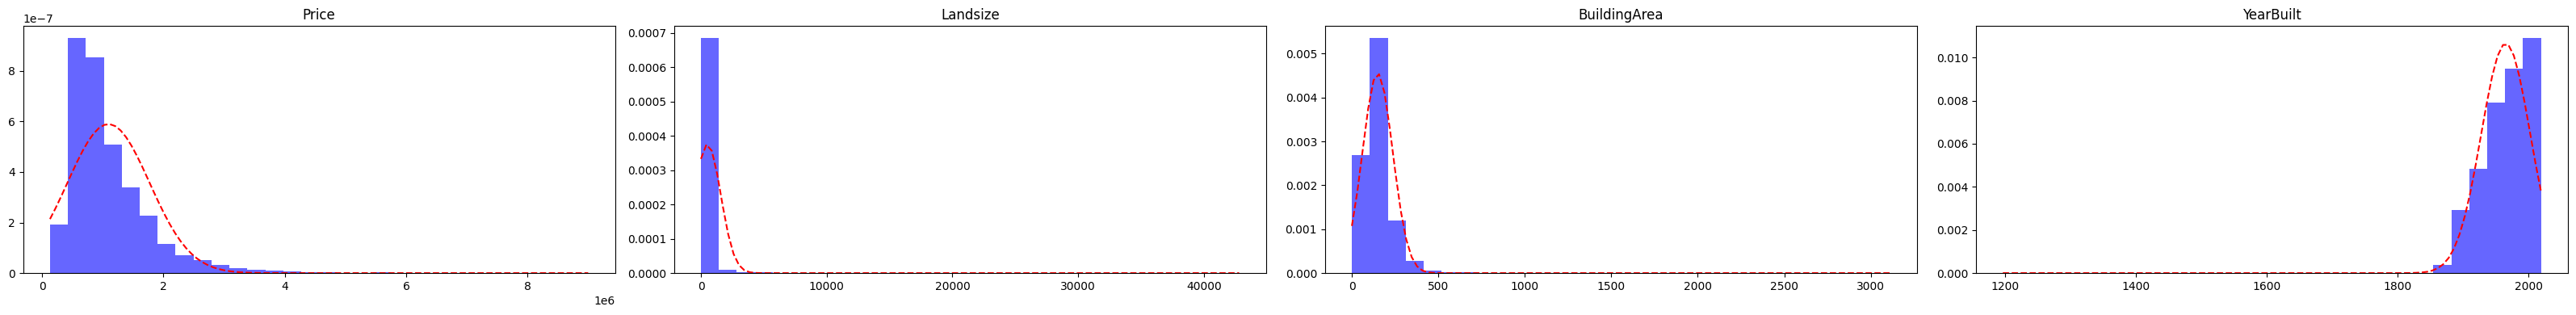

In [15]:
keys = ['Price', 'Landsize', 'BuildingArea', 'YearBuilt']
fig, axes = plt.subplots(ncols=len(keys), figsize=(8 * len(keys), 4))
axes = axes.flatten()

for key, ax in zip(keys, axes):
    ax.hist(df[key].dropna(), density=True, bins=30, alpha=0.6, color='b')
    loc = df[key].mean()
    scale = df[key].std()
    x = np.linspace(df[key].min(), df[key].max(), 100)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    ax.plot(x, y, linestyle='dashed', color='red')
    ax.set_title(key)

plt.tight_layout()
plt.show()


## Визуальный анализ

Построим Q-Q кривую для анализа распределения признаков из нашего датасета. Этот график показывает соответствие между теоретическими значениями квантилей для нормального распределения и реальными значениями из выборки.

Чем ближе график к диагонали, тем более нормальным является распределение значений выборки.

В нашем случае мы будем анализировать распределения `Price`, `Landsize` и `BuildingArea`.


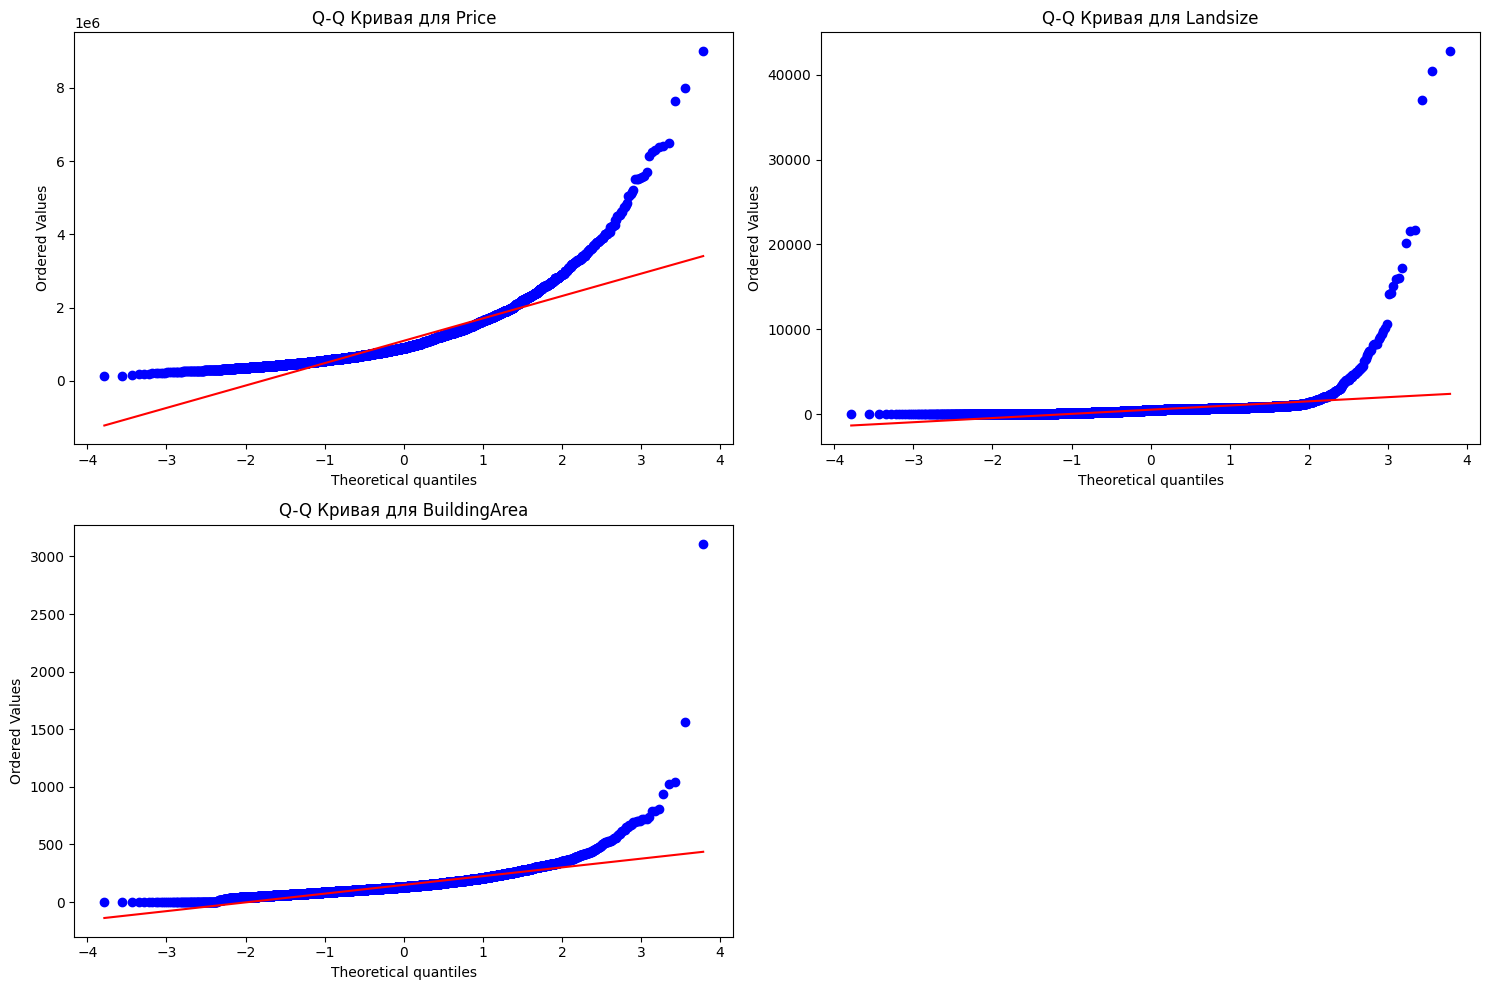

In [36]:
features = ['Price', 'Landsize', 'BuildingArea']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    stats.probplot(df[feature].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Кривая для {feature}')

plt.tight_layout()
plt.show()

### График зависимости цены от площади здания с линией тренда

На графике отображена зависимость между площадью здания (`BuildingArea`) и ценой (`Price`). Для более наглядного анализа данных добавлена линия тренда, построенная с использованием линейной регрессии. Линия тренда показывает общий тренд в данных, помогая увидеть, как изменение площади здания связано с изменением цены.

#### Как рассчитывается линия тренда
- **Коэффициенты линейной регрессии (`b1` и `b0`)**: `b1` вычисляется как отношение ковариации между `BuildingArea` и `Price` к дисперсии `BuildingArea`, что задает наклон линии. `b0` представляет смещение линии и вычисляется исходя из средней цены и средней площади здания.
- **Точки `x` и `y`**: Значения `x` взяты из диапазона значений `BuildingArea`, чтобы покрыть весь спектр данных. Соответствующие значения `y` на линии тренда вычислены с помощью уравнения линейной регрессии.

Линия тренда визуализирует общий тренд в данных, показывая, как в среднем площадь здания влияет на его стоимость.


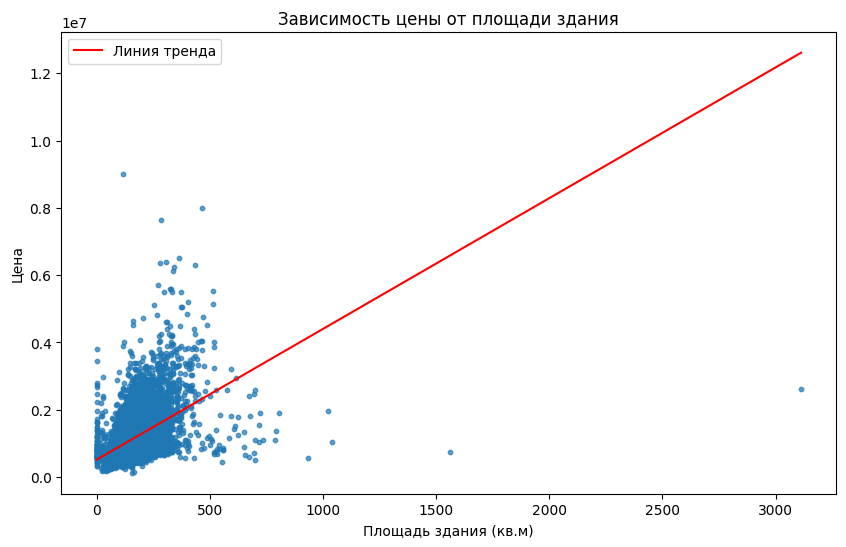

In [40]:
b1 = np.cov(df['BuildingArea'], df['Price'], ddof=1)[0, 1] / np.var(df['BuildingArea'], ddof=1)
b0 = df['Price'].mean() - b1 * df['BuildingArea'].mean()
plt.figure(figsize=(10, 6))
plt.scatter(df['BuildingArea'], df['Price'], s=10, alpha=0.7)
plt.title('Зависимость цены от площади здания')
plt.xlabel('Площадь здания (кв.м)')
plt.ylabel('Цена')

x = np.linspace(df['BuildingArea'].min(), df['BuildingArea'].max(), 1000)
y = b0 + b1 * x
plt.plot(x, y, color='red', label='Линия тренда')
plt.legend()
plt.show()


# Статистический тест на наличие зависимости между ценой и площадью земельного участка



Для анализа зависимости между ценой (`Price`) и площадью земельного участка (`Landsize`) используем **коэффициент корреляции Пирсона**, который проверяет силу и направление линейной связи между двумя переменными. 
#### Коэффициент корреляции Пирсона — это статистическая мера, которая оценивает степень линейной зависимости между двумя переменными. Он используется для определения, насколько сильно связаны две количественные переменные, и варьируется от -1 до 1.

#### Постановка гипотез
- **Нулевая гипотеза \( H_0 \)**: между `Price` и `Landsize` нет линейной зависимости (коэффициент корреляции равен 0).
- **Альтернативная гипотеза \( H_1 \)**: между `Price` и `Landsize` существует линейная зависимость (коэффициент корреляции не равен 0).

#### Шаги выполнения

1. **Загрузка данных**: загружаем данные из файла `Melbourne_housing_FULL.csv`.
2. **Обработка пропусков**: заменяем пропуски в `Price` и `Landsize` на медианные значения, чтобы избежать ошибок при расчётах.
3. **Расчёт коэффициента корреляции и p-значения**: используем функцию `pearsonr` из библиотеки `scipy`, которая возвращает коэффициент корреляции Пирсона и его статистическую значимость (p-значение).


In [21]:
from scipy.stats import pearsonr
import pandas as pd

data = pd.read_csv("Melbourne_housing_FULL.csv")

data['Price'].fillna(data['Price'].median(), inplace=True)
data['Landsize'].fillna(data['Landsize'].median(), inplace=True)

correlation, p_value = pearsonr(data['Price'], data['Landsize'])

print(f"Коэффициент корреляции Пирсона: {correlation}")
print(f"p-значение: {p_value}")


Коэффициент корреляции Пирсона: 0.027305529961458887
p-значение: 3.419610661743816e-07


## Вывод по результатам статистического теста

На основе вычисленного значения **коэффициента корреляции Пирсона** и **p-значения** можно сделать следующие выводы:

1. **Коэффициент корреляции Пирсона**: 0.027. Это значение очень близко к нулю, что указывает на крайне слабую линейную зависимость между `Price` (ценой недвижимости) и `Landsize` (площадью земельного участка).

2. **p-значение**: \( 3.42 \times 10^{-7} \), что значительно меньше 0.05, обычно используемого уровня значимости. Это означает, что мы отвергаем нулевую гипотезу и можем считать, что существует статистически значимая зависимость между `Price` и `Landsize`.

#### Заключение

Хотя зависимость между `Price` и `Landsize` статистически значима, коэффициент корреляции близок к нулю, что указывает на крайне слабую связь. Следовательно, площадь земельного участка почти не влияет на цену недвижимости в этой выборке.


# Отличается ли цена недвижимости для домов разного типа?
Для оценки того, отличается ли цена недвижимости для домов разных типов (`Type`), проведем дисперсионный анализ (ANOVA). Разделим выборку на две группы: дома типа `h` (дома) и `u` (квартиры), затем проведем тест для проверки, зависит ли цена от типа недвижимости.

### Постановка гипотез

- **Нулевая гипотеза (H0)**: Средняя цена домов и квартир не отличается.
- **Альтернативная гипотеза (H1)**: Средняя цена домов и квартир различается.

Для проверки гипотез используем дисперсионный анализ. Если \( F > t \), это будет свидетельствовать о значимых различиях в ценах между типами недвижимости, и мы сможем отклонить нулевую гипотезу.

### Код для проверки различий по цене


In [30]:
from scipy import stats

def var_analysis(df, df1, df2, field):
    all1, all2 = df1.shape[0], df2.shape[0]
    res1_mean, res2_mean, res_mean = df1[field].mean(), df2[field].mean(), df[field].mean()
    SS_b = all1 * (res1_mean - res_mean) ** 2 + all2 * (res2_mean - res_mean) ** 2
    SS_w = ((df1[field] - res1_mean) ** 2).sum() + ((df2[field] - res2_mean) ** 2).sum()
    
    k, n = 2, all1 + all2
    sigma2_b, sigma2_w = SS_b / (k - 1), SS_w / (n - k)
    F = sigma2_b / sigma2_w
    
    alpha = 0.05
    t = stats.f.ppf(1 - alpha, k - 1, n - k)
    
    return F > t

df1 = data[data['Type'] == 'h']  # дома
df2 = data[data['Type'] == 'u']  # квартиры

# Проведение анализа
var_analysis(data, df1, df2, 'Price')

True

In [31]:
res1_mean = df1['Price'].mean()
res2_mean = df2['Price'].mean()

print(f'Цена для домов: {res1_mean}, цена для квартир: {res2_mean}')

Цена для домов: 1127066.2271893243, цена для квартир: 673986.2521584213


## Вывод

Результаты дисперсионного анализа с параметром `Price` подтвердили статистически значимое различие между средней ценой домов и квартир (**F > t**). Это означает, что **цена действительно зависит от типа недвижимости**.

Таким образом, можно заключить, что тип недвижимости оказывает значительное влияние на её стоимость.
